In [6]:
import kagglehub

In [7]:
# Download latest version
path = kagglehub.dataset_download("datafiniti/consumer-reviews-of-amazon-products")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\stefa\.cache\kagglehub\datasets\datafiniti\consumer-reviews-of-amazon-products\versions\5


In [8]:
# Import libraries
import numpy as np
import pandas as pd
import spacy

In [9]:
# Load the medium English model
nlp = spacy.load("en_core_web_md")

In [10]:
# Create df
file_path = r"C:\Users\stefa\.cache\kagglehub\datasets\datafiniti\consumer-reviews-of-amazon-products\versions\5\Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"
df = pd.read_csv(file_path)

print(df.head())

                     id             dateAdded           dateUpdated  \
0  AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
1  AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
2  AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
3  AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
4  AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   

                                                name                  asins  \
0  AmazonBasics AAA Performance Alkaline Batterie...  B00QWO9P0O,B00LH3DMUO   
1  AmazonBasics AAA Performance Alkaline Batterie...  B00QWO9P0O,B00LH3DMUO   
2  AmazonBasics AAA Performance Alkaline Batterie...  B00QWO9P0O,B00LH3DMUO   
3  AmazonBasics AAA Performance Alkaline Batterie...  B00QWO9P0O,B00LH3DMUO   
4  AmazonBasics AAA Performance Alkaline Batterie...  B00QWO9P0O,B00LH3DMUO   

          brand                                         categories  \
0  Amazonbasics  AA,AAA,Heal

In [11]:
# Check for duplicates
df['reviews.username'].duplicated().sum() # (accounting for spam)

np.int64(12063)

In [12]:
df.describe()

,reviews.id,reviews.numHelpful,reviews.rating
count,4.100000e+01,16115.000000,28332.000000
mean,1.840066e+08,0.529321,4.514048
std,2.337036e+07,9.345017,0.934957
min,1.116244e+08,0.000000,1.000000
25%,1.843344e+08,0.000000,4.000000
50%,1.885078e+08,0.000000,5.000000
75%,1.988160e+08,0.000000,5.000000
max,2.085304e+08,621.000000,5.000000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   28332 non-null  object 
 1   dateAdded            28332 non-null  object 
 2   dateUpdated          28332 non-null  object 
 3   name                 28332 non-null  object 
 4   asins                28332 non-null  object 
 5   brand                28332 non-null  object 
 6   categories           28332 non-null  object 
 7   primaryCategories    28332 non-null  object 
 8   imageURLs            28332 non-null  object 
 9   keys                 28332 non-null  object 
 10  manufacturer         28332 non-null  object 
 11  manufacturerNumber   28332 non-null  object 
 12  reviews.date         28332 non-null  object 
 13  reviews.dateSeen     28332 non-null  object 
 14  reviews.didPurchase  9 non-null      object 
 15  reviews.doRecommend  16086 non-null 

In [14]:
num_rows = df.shape[0]
print(f"Number of rows: {num_rows}")

Number of rows: 28332


In [15]:
import string

def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase and strip whitespace
    text = text.lower().strip()
    
    # Process with spaCy
    doc = nlp(text)
    
    # Filter tokens
    cleaned_tokens = [
        token.text for token in doc
        if not token.is_stop                      # Remove stop words
        and token.is_alpha                        # Remove punctuation/numbers
    ]
    
    # Join cleaned tokens into a single string
    return " ".join(cleaned_tokens)

The above code was done to remove spam reviews, and only keeping the most recent review per username. This was done because the last review of every username is more important, since it displays the rating of the most recent 

In [16]:
# Drop rows with missing usernames

df = df[df['reviews.username'].notnull()]

In [17]:
# Apply text cleaning
df['cleaned_text'] = df['reviews.text'].apply(clean_text)

In [18]:
# Dropped all rows from df where 'cleaned_text' has missing values.
clean_data = df.dropna(subset=['cleaned_text']) 

In [19]:
# Sentiment function

from textblob import TextBlob

def analyze_sentiment_textblob(review):
    blob = TextBlob(review)
    polarity = blob.sentiment.polarity

    # Threshold
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'


In [20]:
# Sample reviews

sample_reviews = [
    "I absolutely love this product!",
    "It’s okay, not great.",
    "This is the worst battery I've ever used."
]

for review in sample_reviews:
    sentiment = analyze_sentiment_textblob(review)
    print(f"Review: {review}\nSentiment: {sentiment}\n")

Review: I absolutely love this product!
Sentiment: positive

Review: It’s okay, not great.
Sentiment: neutral

Review: This is the worst battery I've ever used.
Sentiment: negative



In [21]:
# Apply to df

df['sentiment'] = df['cleaned_text'].apply(analyze_sentiment_textblob)


In [22]:
# Check results
print(df[['cleaned_text', 'sentiment']].head())

                                        cleaned_text sentiment
0  order item bad quality missing backup spring p...  negative
1                   bulk expensive way products like  negative
2                               duracell price happy  positive
3                  work brand batteries better price  positive
4                 batteries long lasting price great  positive


In [23]:
# Rating to sentiment function

def rating_to_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

df['rating_sentiment'] = df['reviews.rating'].apply(rating_to_sentiment)


In [24]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(df['rating_sentiment'], df['sentiment'])
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.76


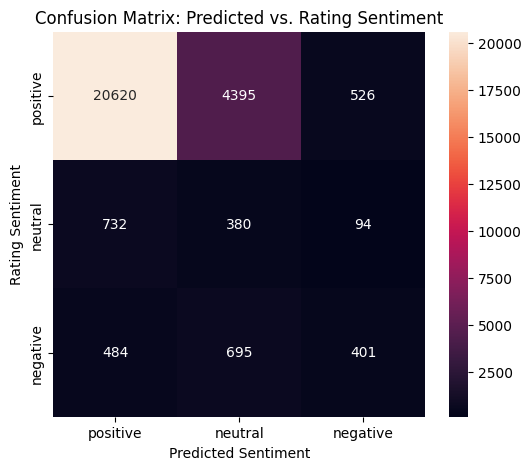

              precision    recall  f1-score   support

    positive       0.39      0.25      0.31      1580
     neutral       0.07      0.32      0.11      1206
    negative       0.94      0.81      0.87     25541

    accuracy                           0.76     28327
   macro avg       0.47      0.46      0.43     28327
weighted avg       0.88      0.76      0.81     28327



In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(df['rating_sentiment'], df['sentiment'], labels=['positive', 'neutral', 'negative'])

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('Rating Sentiment')
plt.title('Confusion Matrix: Predicted vs. Rating Sentiment')
plt.show()

# Print classification report for detailed metrics
print(classification_report(df['rating_sentiment'], df['sentiment'], target_names=['positive', 'neutral', 'negative']))


Overall accuracy: 75.55%


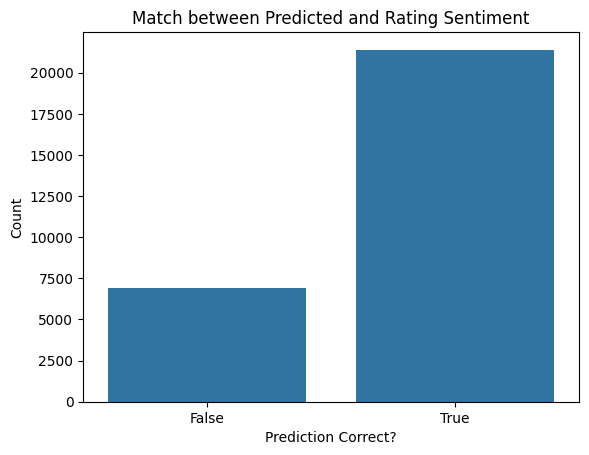

In [26]:
df['match'] = df['sentiment'] == df['rating_sentiment']
accuracy = df['match'].mean()
print(f"Overall accuracy: {accuracy:.2%}")

# Bar chart of matches vs mismatches
sns.countplot(x='match', data=df)
plt.title('Match between Predicted and Rating Sentiment')
plt.xlabel('Prediction Correct?')
plt.ylabel('Count')
plt.show()